In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Hyperparams
batch_size = 128
learning_rate = 0.001
num_classes = 10
epochs_teacher = 2
epochs_student = 2
epochs_fine_tuning = 2
momentum = 0.9
alpha = 0.9
temperature = 3.0
log_interval = 200
learning_rate_fine_tuning = learning_rate / 10

In [3]:
# Data Loaders for CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43273610.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ResNet50 Teacher Model
teacher = torchvision.models.resnet50(weights=None, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.SGD(teacher.parameters(), lr=learning_rate, momentum=momentum)

In [6]:
# Training loop for the Teacher
for epoch in range(epochs_teacher):
    teacher.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        teacher_optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        teacher_optimizer.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:  # Print every 200 mini-batches
            print(f"[Teacher Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / log_interval:.3f}")
            running_loss = 0.0

print("Finished Training Teacher")


[Teacher Epoch 1, Batch 200] Loss: 2.277
[Teacher Epoch 2, Batch 200] Loss: 1.885
Finished Training Teacher


In [7]:
# Student Model: Simple CNN
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
student = StudentCNN().to(device)
student_optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)

In [9]:
# Knowledge Distillation Loss
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=alpha, temperature=temperature):
    hard_loss = nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_outputs / temperature, dim=1),
                             F.softmax(teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature)
    return hard_loss + soft_loss

In [ ]:
# lambda_fairness = 1.0 #fairness regularization

# # Define the fairness loss
# def fairness_loss(outputs, labels, group_ids):
#     group0_mask = (group_ids == 0)
#     group1_mask = (group_ids == 1)

#     group0_loss = nn.CrossEntropyLoss(reduction='mean')(outputs[group0_mask], labels[group0_mask])
#     group1_loss = nn.CrossEntropyLoss(reduction='mean')(outputs[group1_mask], labels[group1_mask])

#     return torch.abs(group0_loss - group1_loss)

# # Modify the distillation loss to include the fairness loss
# def distillation_loss_with_fairness(student_outputs, teacher_outputs, labels, group_ids, alpha=alpha, temperature=temperature):
#     hard_loss = nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)
#     soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_outputs / temperature, dim=1),
#                              F.softmax(teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature)
#     fair_loss = fairness_loss(student_outputs, labels, group_ids)

#     return hard_loss + soft_loss + lambda_fairness * fair_loss

In [11]:
# Train the Student using Knowledge Distillation
teacher.eval()
for epoch in range(epochs_student):
    student.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        student_optimizer.zero_grad()
        student_outputs = student(inputs)
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        loss = distillation_loss(student_outputs, teacher_outputs, labels)
        loss.backward()
        student_optimizer.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:  # Print every log_interval mini-batches
          print(f"[Student (Distillation) Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / log_interval:.3f}")
          running_loss = 0.0

print("Finished Knowledge Distillation")


[Student (Distillation) Epoch 1, Batch 200] Loss: 1.308
[Student (Distillation) Epoch 2, Batch 200] Loss: 0.761
Finished Knowledge Distillation


In [12]:
# Fine-tune the Student
student_optimizer_fine_tuning = optim.SGD(student.parameters(), lr=learning_rate_fine_tuning, momentum=momentum)
for epoch in range(epochs_fine_tuning):
    student.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        student_optimizer_fine_tuning.zero_grad()
        outputs = student(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        student_optimizer_fine_tuning.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"[Student (Fine-tuning) Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / log_interval:.3f}")
            running_loss = 0.0

print("Finished Fine-Tuning Student")

[Student (Fine-tuning) Epoch 1, Batch 200] Loss: 1.883
[Student (Fine-tuning) Epoch 2, Batch 200] Loss: 1.846
Finished Fine-Tuning Student


In [13]:
# Evaluate function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [14]:
# Evaluate both Teacher and Student models
teacher_acc, teacher_preds, teacher_labels = evaluate(teacher, testloader)
student_acc, student_preds, student_labels = evaluate(student, testloader)

In [15]:
# Performance metrics
teacher_precision = precision_score(teacher_labels, teacher_preds, average='weighted')
student_precision = precision_score(student_labels, student_preds, average='weighted')

teacher_recall = recall_score(teacher_labels, teacher_preds, average='weighted')
student_recall = recall_score(student_labels, student_preds, average='weighted')

teacher_f1 = f1_score(teacher_labels, teacher_preds, average='weighted')
student_f1 = f1_score(student_labels, student_preds, average='weighted')

In [16]:
# Model Size
teacher_size = sum(p.numel() for p in teacher.parameters())
student_size = sum(p.numel() for p in student.parameters())

In [17]:
# Inference Time
def infer_time(model, dataloader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
    end_time = time.time()
    return (end_time - start_time) / len(dataloader.dataset)

teacher_infer_time = infer_time(teacher, testloader)
student_infer_time = infer_time(student, testloader)

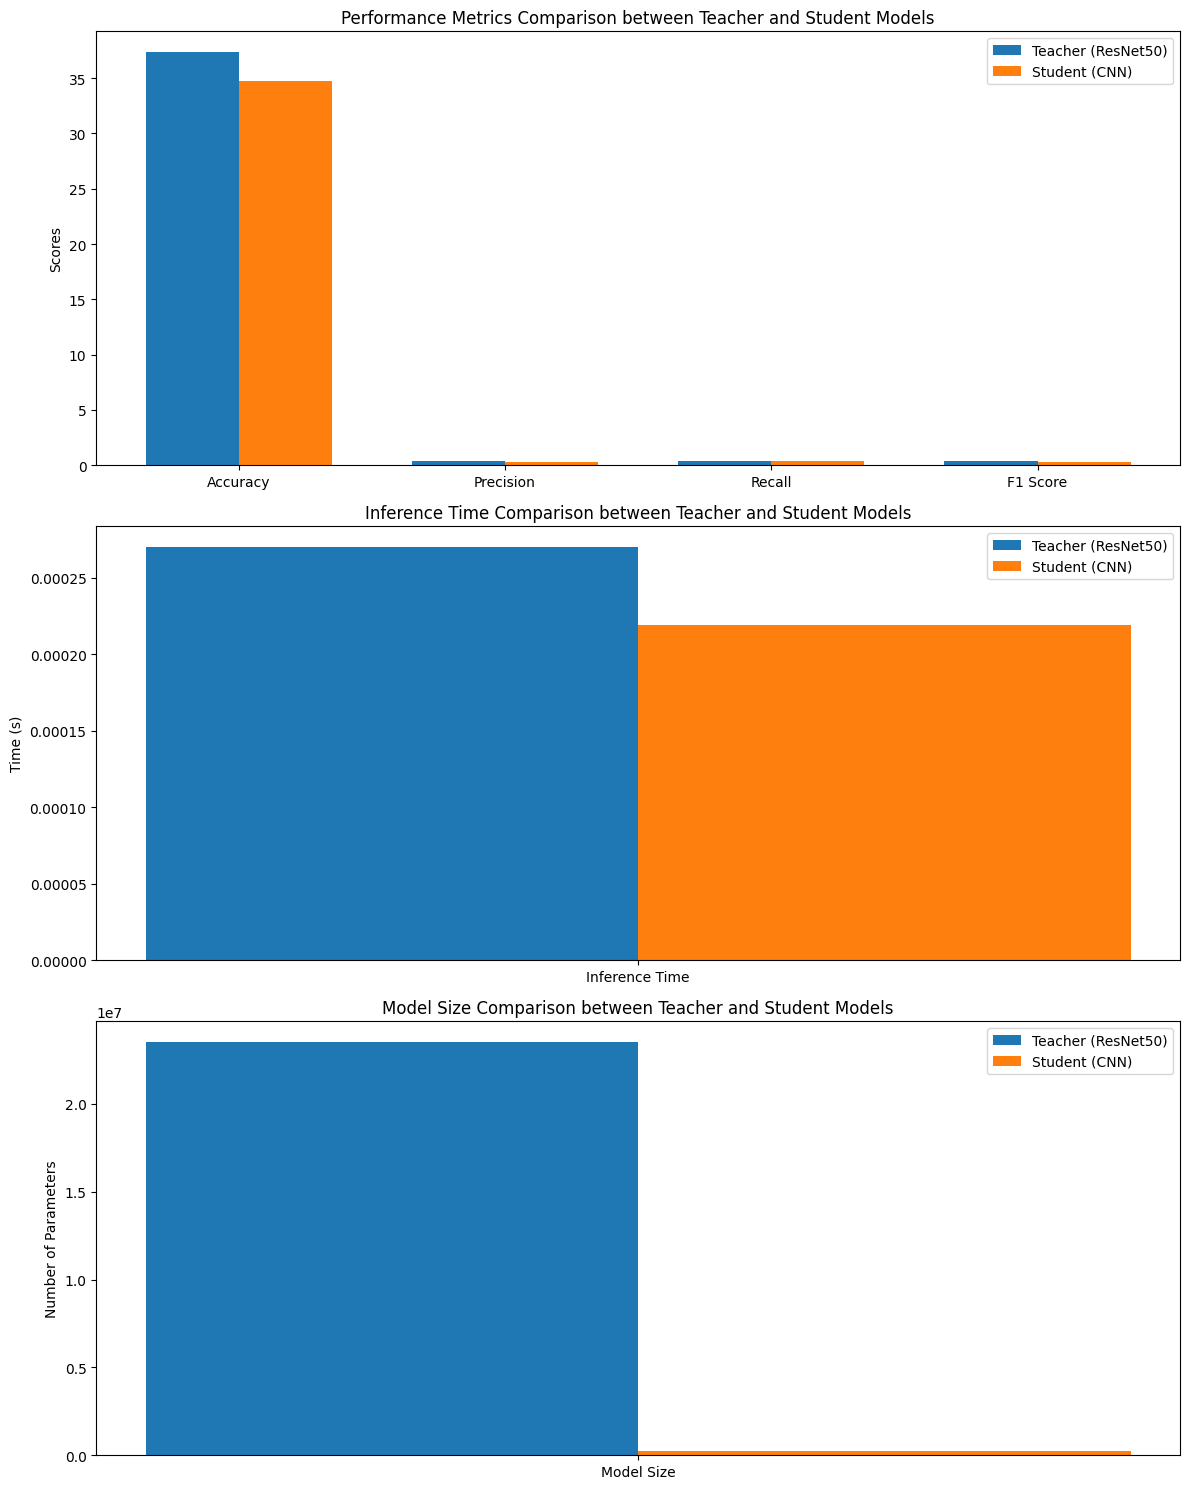

In [19]:
# Visualization

# Split metrics and values
performance_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
performance_teacher_values = [teacher_acc, teacher_precision, teacher_recall, teacher_f1]
performance_student_values = [student_acc, student_precision, student_recall, student_f1]

time_metrics = ['Inference Time']
time_teacher_values = [teacher_infer_time]
time_student_values = [student_infer_time]

size_metrics = ['Model Size']
size_teacher_values = [teacher_size]
size_student_values = [student_size]

x_perf = np.arange(len(performance_metrics))
x_time = np.arange(len(time_metrics))
x_size = np.arange(len(size_metrics))

fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Performance Metrics
axs[0].bar(x_perf - width/2, performance_teacher_values, width, label='Teacher (ResNet50)')
axs[0].bar(x_perf + width/2, performance_student_values, width, label='Student (CNN)')
axs[0].set_ylabel('Scores')
axs[0].set_title('Performance Metrics Comparison between Teacher and Student Models')
axs[0].set_xticks(x_perf)
axs[0].set_xticklabels(performance_metrics)
axs[0].legend()

# Inference Time
axs[1].bar(x_time - width/4, time_teacher_values, width/2, label='Teacher (ResNet50)')
axs[1].bar(x_time + width/4, time_student_values, width/2, label='Student (CNN)')
axs[1].set_ylabel('Time (s)')
axs[1].set_title('Inference Time Comparison between Teacher and Student Models')
axs[1].set_xticks(x_time)
axs[1].set_xticklabels(time_metrics)
axs[1].legend()

# Model Size
axs[2].bar(x_size - width/4, size_teacher_values, width/2, label='Teacher (ResNet50)')
axs[2].bar(x_size + width/4, size_student_values, width/2, label='Student (CNN)')
axs[2].set_ylabel('Number of Parameters')
axs[2].set_title('Model Size Comparison between Teacher and Student Models')
axs[2].set_xticks(x_size)
axs[2].set_xticklabels(size_metrics)
axs[2].legend()

fig.tight_layout()
plt.show()
